In [ ]:
# spacing
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git

  Cloning https://github.com/haven-jeon/PyKoSpacing.git to /tmp/pip-req-build-uonvto2y
  Running command git clone --filter=blob:none --quiet https://github.com/haven-jeon/PyKoSpacing.git /tmp/pip-req-build-uonvto2y
  Resolved https://github.com/haven-jeon/PyKoSpacing.git to commit b32a889cbd10b006d2f4aba118f0cd5b677e2979
  Preparing metadata (setup.py) ... done
  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [ ]:
# 형태소 분석
!pip install konlpy

  Using cached konlpy-0.6.0-py2.py3-none-any.whl.metadata (1.9 kB)
  Using cached JPype1-1.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.9 kB)
Using cached konlpy-0.6.0-py2.py3-none-any.whl (19.4 MB)
Using cached JPype1-1.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (488 kB)


In [ ]:
import pickle
import re

import pandas as pd
from konlpy.tag import Okt
from pykospacing import Spacing
from tqdm.auto import tqdm


def concat_data(data_path: str, *dataframes: pd.DataFrame):
    """
    데이터프레임을 합쳐서 csv 파일로 저장하는 함수
        Args:
            data_path (str): 증강하고자 하는 데이터의 경로
            dataframes (DataFrame): 합치려고 하는 데이터프레임
    """
    result = pd.concat(dataframes)
    result.to_csv(data_path, index=False)


def check_end(noun: str) -> bool:
    """
    한글의 유니코드가 28로 나누어 떨어지면 받침이 없음을 판단
        Args :
            noun (str): 받침 유무를 판단할 명사
        Returns :
            False (bool) : 받침이 없음
            True  (bool) :  받침이 있음
    """
    if (ord(noun[-1]) - ord("가")) % 28 == 0:
        return False
    else:
        return True


def change_josa(noun: str, josa: str) -> str:
    """
    명사의 끝음절 받침 여부에 따라서 조사 교체
        Args :
            none (str): 끝음절의 받침 확인할 명사
            josa (str): 교정할 조사
        Returns :
            josa (str): 교정한 조사
    """
    if josa == "이" or josa == "가":
        return "이" if check_end(noun) else "가"
    elif josa == "은" or josa == "는":
        return "은" if check_end(noun) else "는"
    elif josa == "을" or josa == "를":
        return "을" if check_end(noun) else "를"
    elif josa == "과" or josa == "와":
        return "과" if check_end(noun) else "와"
    else:
        return josa


def make_sentence(sentence: list, compare: str, sym: str) -> str:
    """
    sentence_1, sentence_2에 모두 등장하는 명사를 교체하고 조사를 교정
        Args :
            sentence (list): 형태소 분석한 문장
            compare  (str): 문장에서 바꿀 명사
            sym      (str): 문장 삽입되는 동의어
        Returns :
            replace_sentence (str): 동의어로 교체한 문장
    """
    spacing = Spacing()
    replace_sentence = []
    check = set(["이", "가", "을", "를", "과", "와"])
    for j in range(len(sentence)):
        # 문장에서 동의어를 추가한다.
        if sentence[j][0] == compare:
            replace_sentence.append(sym)
            # 뒷말이 조사면 조사를 확인하고 바꾼다.
            if (
                j + 1 < len(sentence)
                and sentence[j + 1][1] == "Josa"
                and sentence[j + 1][0] in check
            ):
                # 바뀐 명사 마지막 받침 확인 후 조사 변경
                sentence[j + 1] = (
                    change_josa(replace_sentence[-1][0], sentence[j + 1][0]),
                    "Josa",
                )
        else:
            replace_sentence.append(sentence[j][0])

    replace_sentence = "".join(replace_sentence)
    replace_sentence = spacing(replace_sentence)
    return replace_sentence


def sr_noun_replace(data_path: str, wordnet_path: str) -> pd.DataFrame:
    """
    명사와 조사를 교체 증강
        Args :
            data_path    (str): 증강하고자 하는 데이터의 경로
            wordnet_path (str): 동의어 사전 경로
        Returns :
            sr_sentence (DataFrame): 증강된 데이터
    """
    with open(wordnet_path, "rb") as f:
        wordnet = pickle.load(f)

    data = pd.read_csv(data_path)
    okt = Okt()
    n1, n2 = data["sentence_1"], data["sentence_2"]
    sr_sentence = []

    for i in tqdm(range(len(n1)), desc="SR Sentece"):
        now_sentence1 = n1[i]
        now_sentence2 = n2[i]
        noun1 = okt.nouns(now_sentence1)
        noun2 = okt.nouns(now_sentence2)
        # 두 문장에서 공통된 명사를 추출
        compare = set(noun1) & set(noun2)
        for com in compare:
            # 길이가 2이상인지(잘못 고를 수 있음), wordnet에 있는지 확인
            if len(com) > 1 and com in wordnet and len(wordnet[com]) >= 2:
                sym_list = wordnet[com][1:]
                for sym in sym_list:
                    s1 = okt.pos(now_sentence1)
                    s2 = okt.pos(now_sentence2)
                    sr_sentence.append(
                        [
                            data["id"][i],
                            data["source"][i],
                            make_sentence(s1, com, sym),
                            make_sentence(s2, com, sym),
                            data["label"][i],
                            data["binary-label"][i],
                        ]
                    )
    sr_sentence = pd.DataFrame(
        sr_sentence,
        columns=["id", "source", "sentence_1", "sentence_2", "label", "binary-label"],
    )
    return sr_sentence


def sr_augment(source_data_path, dest_data_path, wordnet_path):
    df_source = pd.read_csv(source_data_path)
    df_noun_replaced = sr_noun_replace(source_data_path, wordnet_path)
    df_noun_replaced = df_noun_replaced[df_noun_replaced["label"] >= 1]
    df_source_noun = pd.concat([df_source, df_noun_replaced])
    concat_data(dest_data_path, df_source_noun)


if __name__ == "__main__":
    sr_augment("train.csv", "SR_train_2.csv", "wordnet.pickle")

SR Sentece:   0%|          | 0/9324 [00:00<?, ?it/s]

In [ ]:
import pickle
import re

import pandas as pd
from konlpy.tag import Okt
from pykospacing import Spacing
from tqdm.auto import tqdm


def concat_data(data_path: str, *dataframes: pd.DataFrame):
    """
    데이터프레임을 합쳐서 csv 파일로 저장하는 함수
        Args:
            data_path (str): 증강하고자 하는 데이터의 경로
            dataframes (DataFrame): 합치려고 하는 데이터프레임
    """
    result = pd.concat(dataframes)
    result.to_csv(data_path, index=False)


def check_end(noun: str) -> bool:
    """
    한글의 유니코드가 28로 나누어 떨어지면 받침이 없음을 판단
        Args :
            noun (str): 받침 유무를 판단할 명사
        Returns :
            False (bool) : 받침이 없음
            True  (bool) :  받침이 있음
    """
    if (ord(noun[-1]) - ord("가")) % 28 == 0:
        return False
    else:
        return True


def change_josa(noun: str, josa: str) -> str:
    """
    명사의 끝음절 받침 여부에 따라서 조사 교체
        Args :
            none (str): 끝음절의 받침 확인할 명사
            josa (str): 교정할 조사
        Returns :
            josa (str): 교정한 조사
    """
    if josa == "이" or josa == "가":
        return "이" if check_end(noun) else "가"
    elif josa == "은" or josa == "는":
        return "은" if check_end(noun) else "는"
    elif josa == "을" or josa == "를":
        return "을" if check_end(noun) else "를"
    elif josa == "과" or josa == "와":
        return "과" if check_end(noun) else "와"
    else:
        return josa


def make_sentence(sentence: list, compare: str, sym: str) -> str:
    """
    sentence_1, sentence_2에 모두 등장하는 명사를 교체하고 조사를 교정
        Args :
            sentence (list): 형태소 분석한 문장
            compare  (str): 문장에서 바꿀 명사
            sym      (str): 문장 삽입되는 동의어
        Returns :
            replace_sentence (str): 동의어로 교체한 문장
    """
    spacing = Spacing()
    replace_sentence = []
    check = set(["이", "가", "을", "를", "과", "와"])
    for j in range(len(sentence)):
        # 문장에서 동의어를 추가한다.
        if sentence[j][0] == compare:
            replace_sentence.append(sym)
            # 뒷말이 조사면 조사를 확인하고 바꾼다.
            if (
                j + 1 < len(sentence)
                and sentence[j + 1][1] == "Josa"
                and sentence[j + 1][0] in check
            ):
                # 바뀐 명사 마지막 받침 확인 후 조사 변경
                sentence[j + 1] = (
                    change_josa(replace_sentence[-1][0], sentence[j + 1][0]),
                    "Josa",
                )
        else:
            replace_sentence.append(sentence[j][0])

    replace_sentence = "".join(replace_sentence)
    replace_sentence = spacing(replace_sentence)
    return replace_sentence


def sr_noun_replace(data_path: str, wordnet_path: str) -> pd.DataFrame:
    """
    명사와 조사를 교체 증강
        Args :
            data_path    (str): 증강하고자 하는 데이터의 경로
            wordnet_path (str): 동의어 사전 경로
        Returns :
            sr_sentence (DataFrame): 증강된 데이터
    """
    with open(wordnet_path, "rb") as f:
        wordnet = pickle.load(f)

    data = pd.read_csv(data_path)
    okt = Okt()
    n1, n2 = data["sentence_1"], data["sentence_2"]
    sr_sentence = []

    for i in tqdm(range(len(n1)), desc="SR Sentece"):
        now_sentence1 = n1[i]
        now_sentence2 = n2[i]
        noun1 = okt.nouns(now_sentence1)
        noun2 = okt.nouns(now_sentence2)
        # 두 문장에서 공통된 명사를 추출
        compare = set(noun1) & set(noun2)
        for com in compare:
            # 길이가 2이상인지(잘못 고를 수 있음), wordnet에 있는지 확인
            if len(com) > 1 and com in wordnet and len(wordnet[com]) >= 2:
                sym_list = wordnet[com][1:]
                for sym in sym_list:
                    s1 = okt.pos(now_sentence1)
                    s2 = okt.pos(now_sentence2)
                    sr_sentence.append(
                        [
                            data["id"][i],
                            data["source"][i],
                            make_sentence(s1, com, sym),
                            make_sentence(s2, com, sym),
                            data["label"][i],
                            data["binary-label"][i],
                        ]
                    )
    sr_sentence = pd.DataFrame(
        sr_sentence,
        columns=["id", "source", "sentence_1", "sentence_2", "label", "binary-label"],
    )
    return sr_sentence


def sr_augment(source_data_path, dest_data_path, wordnet_path):
    df_source = pd.read_csv(source_data_path)
    df_noun_replaced = sr_noun_replace(source_data_path, wordnet_path)
    df_noun_replaced = df_noun_replaced[df_noun_replaced["label"] >= 1]
    df_source_noun = pd.concat([df_source, df_noun_replaced])
    concat_data(dest_data_path, df_source_noun)


if __name__ == "__main__":
    sr_augment("dev.csv", "SR_dev_2.csv", "wordnet.pickle")

SR Sentece:   0%|          | 0/550 [00:00<?, ?it/s]

In [ ]:
import pickle
import re

import pandas as pd
from konlpy.tag import Okt
from pykospacing import Spacing
from tqdm.auto import tqdm


def concat_data(data_path: str, *dataframes: pd.DataFrame):
    """
    데이터프레임을 합쳐서 csv 파일로 저장하는 함수
        Args:
            data_path (str): 증강하고자 하는 데이터의 경로
            dataframes (DataFrame): 합치려고 하는 데이터프레임
    """
    result = pd.concat(dataframes)
    result.to_csv(data_path, index=False)


def check_end(noun: str) -> bool:
    """
    한글의 유니코드가 28로 나누어 떨어지면 받침이 없음을 판단
        Args :
            noun (str): 받침 유무를 판단할 명사
        Returns :
            False (bool) : 받침이 없음
            True  (bool) :  받침이 있음
    """
    if (ord(noun[-1]) - ord("가")) % 28 == 0:
        return False
    else:
        return True


def change_josa(noun: str, josa: str) -> str:
    """
    명사의 끝음절 받침 여부에 따라서 조사 교체
        Args :
            none (str): 끝음절의 받침 확인할 명사
            josa (str): 교정할 조사
        Returns :
            josa (str): 교정한 조사
    """
    if josa == "이" or josa == "가":
        return "이" if check_end(noun) else "가"
    elif josa == "은" or josa == "는":
        return "은" if check_end(noun) else "는"
    elif josa == "을" or josa == "를":
        return "을" if check_end(noun) else "를"
    elif josa == "과" or josa == "와":
        return "과" if check_end(noun) else "와"
    else:
        return josa


def make_sentence(sentence: list, compare: str, sym: str) -> str:
    """
    sentence_1, sentence_2에 모두 등장하는 명사를 교체하고 조사를 교정
        Args :
            sentence (list): 형태소 분석한 문장
            compare  (str): 문장에서 바꿀 명사
            sym      (str): 문장 삽입되는 동의어
        Returns :
            replace_sentence (str): 동의어로 교체한 문장
    """
    spacing = Spacing()
    replace_sentence = []
    check = set(["이", "가", "을", "를", "과", "와"])
    for j in range(len(sentence)):
        # 문장에서 동의어를 추가한다.
        if sentence[j][0] == compare:
            replace_sentence.append(sym)
            # 뒷말이 조사면 조사를 확인하고 바꾼다.
            if (
                j + 1 < len(sentence)
                and sentence[j + 1][1] == "Josa"
                and sentence[j + 1][0] in check
            ):
                # 바뀐 명사 마지막 받침 확인 후 조사 변경
                sentence[j + 1] = (
                    change_josa(replace_sentence[-1][0], sentence[j + 1][0]),
                    "Josa",
                )
        else:
            replace_sentence.append(sentence[j][0])

    replace_sentence = "".join(replace_sentence)
    replace_sentence = spacing(replace_sentence)
    return replace_sentence


def sr_noun_replace(data_path: str, wordnet_path: str) -> pd.DataFrame:
    """
    명사와 조사를 교체 증강
        Args :
            data_path    (str): 증강하고자 하는 데이터의 경로
            wordnet_path (str): 동의어 사전 경로
        Returns :
            sr_sentence (DataFrame): 증강된 데이터
    """
    with open(wordnet_path, "rb") as f:
        wordnet = pickle.load(f)

    data = pd.read_csv(data_path)
    okt = Okt()
    n1, n2 = data["sentence_1"], data["sentence_2"]
    sr_sentence = []

    for i in tqdm(range(len(n1)), desc="SR Sentece"):
        now_sentence1 = n1[i]
        now_sentence2 = n2[i]
        noun1 = okt.nouns(now_sentence1)
        noun2 = okt.nouns(now_sentence2)
        # 두 문장에서 공통된 명사를 추출
        compare = set(noun1) & set(noun2)
        for com in compare:
            # 길이가 2이상인지(잘못 고를 수 있음), wordnet에 있는지 확인
            if len(com) > 1 and com in wordnet and len(wordnet[com]) >= 2:
                sym_list = wordnet[com][1:]
                for sym in sym_list:
                    s1 = okt.pos(now_sentence1)
                    s2 = okt.pos(now_sentence2)
                    sr_sentence.append(
                        [
                            data["id"][i],
                            data["source"][i],
                            make_sentence(s1, com, sym),
                            make_sentence(s2, com, sym),
                            data["label"][i],
                            data["binary-label"][i],
                        ]
                    )
    sr_sentence = pd.DataFrame(
        sr_sentence,
        columns=["id", "source", "sentence_1", "sentence_2", "label", "binary-label"],
    )
    return sr_sentence


def sr_augment(source_data_path, dest_data_path, wordnet_path):
    df_source = pd.read_csv(source_data_path)
    df_noun_replaced = sr_noun_replace(source_data_path, wordnet_path)
    df_noun_replaced = df_noun_replaced[df_noun_replaced["label"] >= 1]
    df_source_noun = pd.concat([df_source, df_noun_replaced])
    concat_data(dest_data_path, df_source_noun)


if __name__ == "__main__":
    sr_augment("train_all.csv", "SR_train_3.csv", "wordnet.pickle")

SR Sentece:   0%|          | 0/9324 [00:00<?, ?it/s]

In [ ]:
import pickle
import re

import pandas as pd
from konlpy.tag import Okt
from pykospacing import Spacing
from tqdm.auto import tqdm


def concat_data(data_path: str, *dataframes: pd.DataFrame):
    """
    데이터프레임을 합쳐서 csv 파일로 저장하는 함수
        Args:
            data_path (str): 증강하고자 하는 데이터의 경로
            dataframes (DataFrame): 합치려고 하는 데이터프레임
    """
    result = pd.concat(dataframes)
    result.to_csv(data_path, index=False)


def check_end(noun: str) -> bool:
    """
    한글의 유니코드가 28로 나누어 떨어지면 받침이 없음을 판단
        Args :
            noun (str): 받침 유무를 판단할 명사
        Returns :
            False (bool) : 받침이 없음
            True  (bool) :  받침이 있음
    """
    if (ord(noun[-1]) - ord("가")) % 28 == 0:
        return False
    else:
        return True


def change_josa(noun: str, josa: str) -> str:
    """
    명사의 끝음절 받침 여부에 따라서 조사 교체
        Args :
            none (str): 끝음절의 받침 확인할 명사
            josa (str): 교정할 조사
        Returns :
            josa (str): 교정한 조사
    """
    if josa == "이" or josa == "가":
        return "이" if check_end(noun) else "가"
    elif josa == "은" or josa == "는":
        return "은" if check_end(noun) else "는"
    elif josa == "을" or josa == "를":
        return "을" if check_end(noun) else "를"
    elif josa == "과" or josa == "와":
        return "과" if check_end(noun) else "와"
    else:
        return josa


def make_sentence(sentence: list, compare: str, sym: str) -> str:
    """
    sentence_1, sentence_2에 모두 등장하는 명사를 교체하고 조사를 교정
        Args :
            sentence (list): 형태소 분석한 문장
            compare  (str): 문장에서 바꿀 명사
            sym      (str): 문장 삽입되는 동의어
        Returns :
            replace_sentence (str): 동의어로 교체한 문장
    """
    spacing = Spacing()
    replace_sentence = []
    check = set(["이", "가", "을", "를", "과", "와"])
    for j in range(len(sentence)):
        # 문장에서 동의어를 추가한다.
        if sentence[j][0] == compare:
            replace_sentence.append(sym)
            # 뒷말이 조사면 조사를 확인하고 바꾼다.
            if (
                j + 1 < len(sentence)
                and sentence[j + 1][1] == "Josa"
                and sentence[j + 1][0] in check
            ):
                # 바뀐 명사 마지막 받침 확인 후 조사 변경
                sentence[j + 1] = (
                    change_josa(replace_sentence[-1][0], sentence[j + 1][0]),
                    "Josa",
                )
        else:
            replace_sentence.append(sentence[j][0])

    replace_sentence = "".join(replace_sentence)
    replace_sentence = spacing(replace_sentence)
    return replace_sentence


def sr_noun_replace(data_path: str, wordnet_path: str) -> pd.DataFrame:
    """
    명사와 조사를 교체 증강
        Args :
            data_path    (str): 증강하고자 하는 데이터의 경로
            wordnet_path (str): 동의어 사전 경로
        Returns :
            sr_sentence (DataFrame): 증강된 데이터
    """
    with open(wordnet_path, "rb") as f:
        wordnet = pickle.load(f)

    data = pd.read_csv(data_path)
    okt = Okt()
    n1, n2 = data["sentence_1"], data["sentence_2"]
    sr_sentence = []

    for i in tqdm(range(len(n1)), desc="SR Sentece"):
        now_sentence1 = n1[i]
        now_sentence2 = n2[i]
        noun1 = okt.nouns(now_sentence1)
        noun2 = okt.nouns(now_sentence2)
        # 두 문장에서 공통된 명사를 추출
        compare = set(noun1) & set(noun2)
        for com in compare:
            # 길이가 2이상인지(잘못 고를 수 있음), wordnet에 있는지 확인
            if len(com) > 1 and com in wordnet and len(wordnet[com]) >= 2:
                sym_list = wordnet[com][1:]
                for sym in sym_list:
                    s1 = okt.pos(now_sentence1)
                    s2 = okt.pos(now_sentence2)
                    sr_sentence.append(
                        [
                            data["id"][i],
                            data["source"][i],
                            make_sentence(s1, com, sym),
                            make_sentence(s2, com, sym),
                            data["label"][i],
                            data["binary-label"][i],
                        ]
                    )
    sr_sentence = pd.DataFrame(
        sr_sentence,
        columns=["id", "source", "sentence_1", "sentence_2", "label", "binary-label"],
    )
    return sr_sentence


def sr_augment(source_data_path, dest_data_path, wordnet_path):
    df_source = pd.read_csv(source_data_path)
    df_noun_replaced = sr_noun_replace(source_data_path, wordnet_path)
    df_noun_replaced = df_noun_replaced[df_noun_replaced["label"] >= 1]
    df_source_noun = pd.concat([df_source, df_noun_replaced])
    concat_data(dest_data_path, df_source_noun)


if __name__ == "__main__":
    sr_augment("dev_all.csv", "SR_dev_3.csv", "wordnet.pickle")

SR Sentece:   0%|          | 0/550 [00:00<?, ?it/s]

In [ ]:
import pickle
import re

import pandas as pd
from konlpy.tag import Okt
from pykospacing import Spacing
from tqdm.auto import tqdm


def concat_data(data_path: str, *dataframes: pd.DataFrame):
    """
    데이터프레임을 합쳐서 csv 파일로 저장하는 함수
        Args:
            data_path (str): 증강하고자 하는 데이터의 경로
            dataframes (DataFrame): 합치려고 하는 데이터프레임
    """
    result = pd.concat(dataframes)
    result.to_csv(data_path, index=False)


def check_end(noun: str) -> bool:
    """
    한글의 유니코드가 28로 나누어 떨어지면 받침이 없음을 판단
        Args :
            noun (str): 받침 유무를 판단할 명사
        Returns :
            False (bool) : 받침이 없음
            True  (bool) :  받침이 있음
    """
    if (ord(noun[-1]) - ord("가")) % 28 == 0:
        return False
    else:
        return True


def change_josa(noun: str, josa: str) -> str:
    """
    명사의 끝음절 받침 여부에 따라서 조사 교체
        Args :
            none (str): 끝음절의 받침 확인할 명사
            josa (str): 교정할 조사
        Returns :
            josa (str): 교정한 조사
    """
    if josa == "이" or josa == "가":
        return "이" if check_end(noun) else "가"
    elif josa == "은" or josa == "는":
        return "은" if check_end(noun) else "는"
    elif josa == "을" or josa == "를":
        return "을" if check_end(noun) else "를"
    elif josa == "과" or josa == "와":
        return "과" if check_end(noun) else "와"
    else:
        return josa


def make_sentence(sentence: list, compare: str, sym: str) -> str:
    """
    sentence_1, sentence_2에 모두 등장하는 명사를 교체하고 조사를 교정
        Args :
            sentence (list): 형태소 분석한 문장
            compare  (str): 문장에서 바꿀 명사
            sym      (str): 문장 삽입되는 동의어
        Returns :
            replace_sentence (str): 동의어로 교체한 문장
    """
    spacing = Spacing()
    replace_sentence = []
    check = set(["이", "가", "을", "를", "과", "와"])
    for j in range(len(sentence)):
        # 문장에서 동의어를 추가한다.
        if sentence[j][0] == compare:
            replace_sentence.append(sym)
            # 뒷말이 조사면 조사를 확인하고 바꾼다.
            if (
                j + 1 < len(sentence)
                and sentence[j + 1][1] == "Josa"
                and sentence[j + 1][0] in check
            ):
                # 바뀐 명사 마지막 받침 확인 후 조사 변경
                sentence[j + 1] = (
                    change_josa(replace_sentence[-1][0], sentence[j + 1][0]),
                    "Josa",
                )
        else:
            replace_sentence.append(sentence[j][0])

    replace_sentence = "".join(replace_sentence)
    replace_sentence = spacing(replace_sentence)
    return replace_sentence


def sr_noun_replace(data_path: str, wordnet_path: str) -> pd.DataFrame:
    """
    명사와 조사를 교체 증강
        Args :
            data_path    (str): 증강하고자 하는 데이터의 경로
            wordnet_path (str): 동의어 사전 경로
        Returns :
            sr_sentence (DataFrame): 증강된 데이터
    """
    with open(wordnet_path, "rb") as f:
        wordnet = pickle.load(f)

    data = pd.read_csv(data_path)
    okt = Okt()
    n1, n2 = data["sentence_1"], data["sentence_2"]
    sr_sentence = []

    for i in tqdm(range(len(n1)), desc="SR Sentece"):
        now_sentence1 = n1[i]
        now_sentence2 = n2[i]
        noun1 = okt.nouns(now_sentence1)
        noun2 = okt.nouns(now_sentence2)
        # 두 문장에서 공통된 명사를 추출
        compare = set(noun1) & set(noun2)
        for com in compare:
            # 길이가 2이상인지(잘못 고를 수 있음), wordnet에 있는지 확인
            if len(com) > 1 and com in wordnet and len(wordnet[com]) >= 2:
                sym_list = wordnet[com][1:]
                for sym in sym_list:
                    s1 = okt.pos(now_sentence1)
                    s2 = okt.pos(now_sentence2)
                    sr_sentence.append(
                        [
                            data["id"][i],
                            data["source"][i],
                            make_sentence(s1, com, sym),
                            make_sentence(s2, com, sym),
                            data["label"][i],
                            data["binary-label"][i],
                        ]
                    )
    sr_sentence = pd.DataFrame(
        sr_sentence,
        columns=["id", "source", "sentence_1", "sentence_2", "label", "binary-label"],
    )
    return sr_sentence


def sr_augment(source_data_path, dest_data_path, wordnet_path):
    df_source = pd.read_csv(source_data_path)
    df_noun_replaced = sr_noun_replace(source_data_path, wordnet_path)
    df_noun_replaced = df_noun_replaced[df_noun_replaced["label"] > 0]
    df_source_noun = pd.concat([df_source, df_noun_replaced])
    concat_data(dest_data_path, df_source_noun)


if __name__ == "__main__":
    sr_augment("train_all.csv", "SR_train_4.csv", "wordnet.pickle")

SR Sentece:   0%|          | 0/9324 [00:00<?, ?it/s]

In [ ]:
import pandas as pd

df = pd.read_csv('train.csv')

total_count = len(df)
label_zero_count = (df['label'] == 0).sum()
label_zero_ratio = label_zero_count / total_count

print(f"전체 데이터 개수: {total_count}")
print(f"Label이 0인 데이터 개수: {label_zero_count}")
print(f"Label이 0인 데이터 비율: {label_zero_ratio:.2%}")

전체 데이터 개수: 9324
Label이 0인 데이터 개수: 2119
Label이 0인 데이터 비율: 22.73%


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPyt

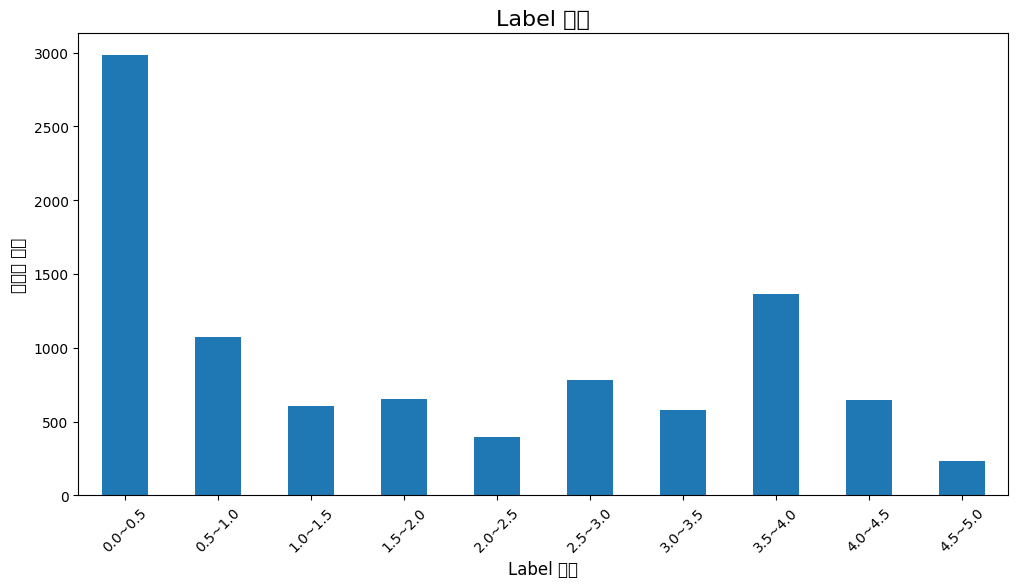

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

min_label = df['label'].min()
max_label = df['label'].max()

bins = np.arange(min_label, max_label + 0.5, 0.5)

labels = [f'{round(bins[i], 1)}~{round(bins[i+1], 1)}' for i in range(len(bins)-1)]

df['label_range'] = pd.cut(df['label'], bins=bins, labels=labels, include_lowest=True)

label_range_counts = df['label_range'].value_counts().sort_index()

# 막대 그래프 시각화
plt.figure(figsize=(12, 6))
label_range_counts.plot(kind='bar')
plt.title('Label 분포', fontsize=16)
plt.xlabel('Label 범위', fontsize=12)
plt.ylabel('데이터 개수', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [ ]:
import pandas as pd

sr_df = pd.read_csv('SR_train_3.csv')

total_count = len(sr_df)
label_zero_count = (sr_df['label'] == 0).sum()
label_zero_ratio = label_zero_count / total_count

print(f"전체 데이터 개수: {total_count}")
print(f"Label이 0인 데이터 개수: {label_zero_count}")
print(f"Label이 0인 데이터 비율: {label_zero_ratio:.2%}")

전체 데이터 개수: 13763
Label이 0인 데이터 개수: 2119
Label이 0인 데이터 비율: 15.40%


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPyt

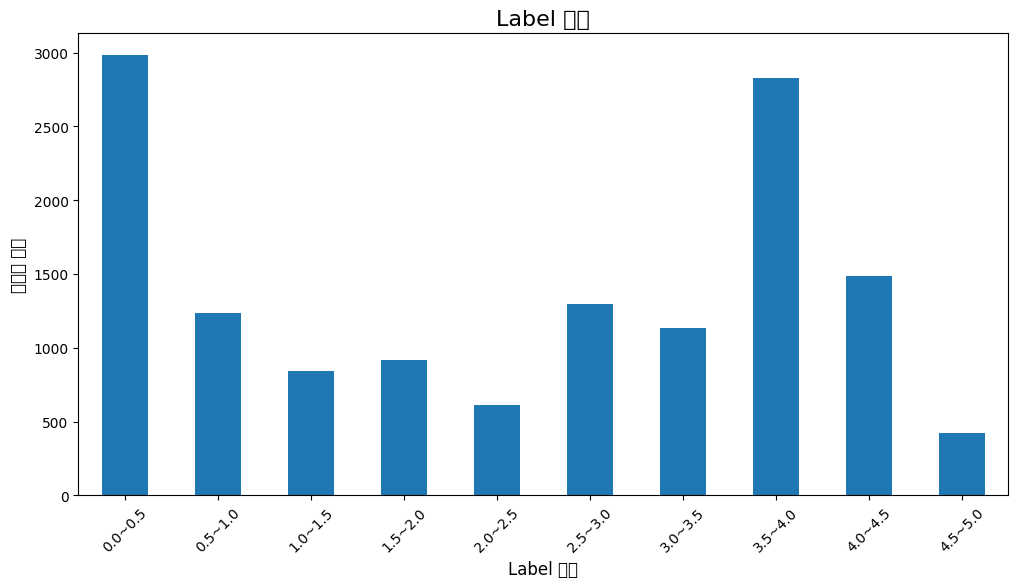

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

min_label = sr_df['label'].min()
max_label = sr_df['label'].max()

bins = np.arange(min_label, max_label + 0.5, 0.5)

labels = [f'{round(bins[i], 1)}~{round(bins[i+1], 1)}' for i in range(len(bins)-1)]

sr_df['label_range'] = pd.cut(sr_df['label'], bins=bins, labels=labels, include_lowest=True)

label_range_counts = sr_df['label_range'].value_counts().sort_index()

# 막대 그래프 시각화
plt.figure(figsize=(12, 6))
label_range_counts.plot(kind='bar')
plt.title('Label 분포', fontsize=16)
plt.xlabel('Label 범위', fontsize=12)
plt.ylabel('데이터 개수', fontsize=12)
plt.xticks(rotation=45)
plt.show()